<a href="https://colab.research.google.com/github/olga-terekhova/data-analysis/blob/main/data-analysis/vendor-extracurriculars-choice/vendor_extracurriculars_choice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installations and imports

In [93]:
! pip install pymupdf pillow

In [94]:
!java -version
!pip install -q tabula-py
!pip install jpype1

openjdk version "11.0.23" 2024-04-16
OpenJDK Runtime Environment (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)


In [95]:
!pip install pyspark findspark

In [96]:
import requests
import re
import tabula
import pandas as pd
import matplotlib.pyplot as plt

In [97]:
import findspark
findspark.init()

In [98]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("vendor-extracurriculars-choice").getOrCreate()

In [99]:
from pyspark.sql import functions as F
import pyspark.sql.types as pys_types

##Download source data file

### LOI index

In [100]:
pdf_url = "https://github.com/olga-terekhova/data-analysis/raw/main/vendor-extracurriculars-choice/data/LOI2023.pdf"

# Download the PDF file
response = requests.get(pdf_url)
pdf_path = 'LOI2023.pdf'

# Save the PDF file locally
with open(pdf_path, 'wb') as f:
    f.write(response.content)

### Vendor classes availability by school

In [101]:
url_v = "https://raw.githubusercontent.com/olga-terekhova/data-analysis/main/vendor-extracurriculars-choice/data/find_your_school"

# Download the file with list of schools
response_v = requests.get(url_v)
path_v = 'find_your_school'

# Save the file locally
with open(path_v, 'wb') as f:
    f.write(response_v.content)

## Create datasets

### Check areas

Check that area boundaries identified for tables within pdf contain the table fully, not including headers. The script creates snapshots for the selected area for all pages with tables

NB: area notation for fizz is (left, top, right, bottom), while tabula uses (top, left, bottom, right)

In [102]:
def dowload_area_pictures():
  import fitz  # PyMuPDF
  from PIL import Image

  # Open the PDF file
  pdf_path = "LOI2023.pdf"
  document = fitz.open(pdf_path)

  for i in range(6,21):
    # Select current page
    page = document[i]

    # Specify the rectangular area (coordinates in points)
    rect = fitz.Rect(20, 105, 770, 560)

    # Get the pixmap (image) of the specified rectangular area
    pix = page.get_pixmap(clip=rect)

    # Save the image
    image_path = 'output_image' + str(i) + '.png'
    pix.save(image_path)

    # Convert the pixmap to a PIL Image and display it (optional)
    image = Image.open(image_path)
    image.show()



### Extract dataframe with LOI index

In [103]:
tabula.environment_info()

Python version:
    3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Java version:
    openjdk version "11.0.23" 2024-04-16
OpenJDK Runtime Environment (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)
tabula-py version: 2.9.3
platform: Linux-6.1.85+-x86_64-with-glibc2.35
uname:
    uname_result(system='Linux', node='f787e439e59e', release='6.1.85+', version='#1 SMP PREEMPT_DYNAMIC Fri May 24 14:06:39 UTC 2024', machine='x86_64')
linux_distribution: ('Ubuntu', '22.04', 'jammy')
mac_ver: ('', ('', '', ''), '')


In [104]:
table_header = ['School ID', 'School Name', 'LOI 2023 Rank', 'LOI 2020 Rank', 'LOI 2017 Rank', 'LOI 2014 Rank', 'LOI 2011 Rank', 'LOI Scores', 'Ward', 'Learning Centre']

In [105]:
dfs = tabula.read_pdf(pdf_path, stream=True, pages="7-21", area=[105, 20, 560, 770], pandas_options={'header': None}, multiple_tables=False)
print(len(dfs))
df = dfs[0]
df.columns = table_header
df

1


,School ID,School Name,LOI 2023 Rank,LOI 2020 Rank,LOI 2017 Rank,LOI 2014 Rank,LOI 2011 Rank,LOI Scores,Ward,Learning Centre
0,247,Shoreham Public Sports and Wellness Academy,1,1.0,2.0,4.0,3.0,0.99008 0.98770 0.98518 0.98136 0.98669,4,LC2
1,296,Yorkwoods Public School,2,2.0,1.0,6.0,10.0,0.98826 0.98608 0.98569 0.97785 0.96735,4,LC2
2,209,Oakdale Park Middle School,3,11.0,12.0,13.0,20.0,0.97943 0.97062 0.96608 0.95863 0.94432,4,LC2
3,126,Flemington Public School,4,4.0,3.0,3.0,7.0,0.97858 0.98468 0.98399 0.98254 0.98003,8,LC1
4,1146,Eastview Public School,5,18.0,21.0,17.0,16.0,0.97632 0.95736 0.94198 0.95011 0.95181,19,LC3
...,...,...,...,...,...,...,...,...,...,...
465,1361,Maurice Cody Junior Public School,466,467.0,464.0,466.0,470.0,0.00961 0.00948 0.00901 0.00662 0.00822,11,LC1
466,1415,Whitney Junior Public School,467,472.0,471.0,473.0,479.0,0.00826 0.00091 0.00059 0.00065 0.00012,10,LC4
467,1060,Lambton‐Kingsway Junior Middle School,468,471.0,469.0,472.0,476.0,0.00590 0.00359 0.00152 0.00114 0.00135,3,LC4
468,1083,Sunnylea Junior School,469,470.0,465.0,469.0,475.0,0.00386 0.00382 0.00781 0.00426 0.00347,3,LC4


In [106]:
print(df.dtypes)

School ID            int64
School Name         object
LOI 2023 Rank        int64
LOI 2020 Rank      float64
LOI 2017 Rank      float64
LOI 2014 Rank      float64
LOI 2011 Rank      float64
LOI Scores          object
Ward                 int64
Learning Centre     object
dtype: object


In [107]:
df['LOI 2023 Rank'] = df['LOI 2023 Rank'].fillna(0).astype(int)
df['LOI 2020 Rank'] = df['LOI 2020 Rank'].fillna(0).astype(int)
df['LOI 2017 Rank'] = df['LOI 2017 Rank'].fillna(0).astype(int)
df['LOI 2014 Rank'] = df['LOI 2014 Rank'].fillna(0).astype(int)
df['LOI 2011 Rank'] = df['LOI 2011 Rank'].fillna(0).astype(int)

In [108]:
df

,School ID,School Name,LOI 2023 Rank,LOI 2020 Rank,LOI 2017 Rank,LOI 2014 Rank,LOI 2011 Rank,LOI Scores,Ward,Learning Centre
0,247,Shoreham Public Sports and Wellness Academy,1,1,2,4,3,0.99008 0.98770 0.98518 0.98136 0.98669,4,LC2
1,296,Yorkwoods Public School,2,2,1,6,10,0.98826 0.98608 0.98569 0.97785 0.96735,4,LC2
2,209,Oakdale Park Middle School,3,11,12,13,20,0.97943 0.97062 0.96608 0.95863 0.94432,4,LC2
3,126,Flemington Public School,4,4,3,3,7,0.97858 0.98468 0.98399 0.98254 0.98003,8,LC1
4,1146,Eastview Public School,5,18,21,17,16,0.97632 0.95736 0.94198 0.95011 0.95181,19,LC3
...,...,...,...,...,...,...,...,...,...,...
465,1361,Maurice Cody Junior Public School,466,467,464,466,470,0.00961 0.00948 0.00901 0.00662 0.00822,11,LC1
466,1415,Whitney Junior Public School,467,472,471,473,479,0.00826 0.00091 0.00059 0.00065 0.00012,10,LC4
467,1060,Lambton‐Kingsway Junior Middle School,468,471,469,472,476,0.00590 0.00359 0.00152 0.00114 0.00135,3,LC4
468,1083,Sunnylea Junior School,469,470,465,469,475,0.00386 0.00382 0.00781 0.00426 0.00347,3,LC4


In [109]:
dfs_loi = spark.createDataFrame(df)
print(dfs_loi.count())
dfs_loi.show()

470
+---------+--------------------+-------------+-------------+-------------+-------------+-------------+--------------------+----+---------------+
|School ID|         School Name|LOI 2023 Rank|LOI 2020 Rank|LOI 2017 Rank|LOI 2014 Rank|LOI 2011 Rank|          LOI Scores|Ward|Learning Centre|
+---------+--------------------+-------------+-------------+-------------+-------------+-------------+--------------------+----+---------------+
|      247|Shoreham Public S...|            1|            1|            2|            4|            3|0.99008 0.98770 0...|   4|            LC2|
|      296|Yorkwoods Public ...|            2|            2|            1|            6|           10|0.98826 0.98608 0...|   4|            LC2|
|      209|Oakdale Park Midd...|            3|           11|           12|           13|           20|0.97943 0.97062 0...|   4|            LC2|
|      126|Flemington Public...|            4|            4|            3|            3|            7|0.97858 0.98468 0...|   

### Extract dataframe with the list of schools

In [110]:
df_v = pd.read_json(path_v)
df_v

,school_id,school_name
0,8,Adam Beck Junior Public School
1,44,AMG and The Grove Alternative School (AMG-The ...
2,5,Associated Hebrew Schools - Posluns
3,114,Balmy Beach Community School
4,45,Bedford Park Public School
5,47,Bessborough Drive Elementary and Middle School
6,27,Brown Junior Public School
7,73,Claude Watson School for the Arts (Junior & Mi...
8,1,Cottingham Public School
9,16,Dallington Public School\t\t\t


In [111]:
dfs_v = spark.createDataFrame(df_v)
print(dfs_v.count())
dfs_v.show()

54
+---------+--------------------+
|school_id|         school_name|
+---------+--------------------+
|        8|Adam Beck Junior ...|
|       44|AMG and The Grove...|
|        5|Associated Hebrew...|
|      114|Balmy Beach Commu...|
|       45|Bedford Park Publ...|
|       47|Bessborough Drive...|
|       27|Brown Junior Publ...|
|       73|Claude Watson Sch...|
|        1|Cottingham Public...|
|       16|Dallington Public...|
|       25|Davisville Junior...|
|       15|Denlow Public Sch...|
|       40|Dr. Rita Cox - Ki...|
|       17|Earl Beatty Junio...|
|       95|École élémentaire...|
|       30|Essex Junior and ...|
|       24|Fern Avenue Junio...|
|       42|Forest Hill Junio...|
|       35|Frankland Communi...|
|       43|Humewood Communit...|
+---------+--------------------+
only showing top 20 rows



## Transform datasets

### Define rules for clean up

In [112]:
def clean_up_school_name(school_name):

    school_name = school_name.lower()
    school_name = school_name.strip()

    remove_substrings = ["\t",".", "public ", "school", "junior", \
                         "elementary", "and senior", "middle", "&", "(", ")"]
    for substring in remove_substrings:
      school_name = school_name.replace(substring, "")

    school_name = school_name.replace("j r", "jr")
    school_name = school_name.replace('‐', '-') # replacing 8208 hyphen with 45 hyphen
    school_name = school_name.replace('minogok','minagok')

    delimiter = "/"
    delimiter_index = school_name.find(delimiter)
    if delimiter_index != -1:
        school_name = school_name[:delimiter_index]

    school_name = re.sub(r'\s+', ' ', school_name)

    school_name = school_name.strip()

    return school_name

clean_up_school_name_udf = F.udf(clean_up_school_name, pys_types.StringType())

### Clean up LOI dataset

In [113]:
dfs_loi = dfs_loi.withColumn("simple_school_name",clean_up_school_name_udf(dfs_loi["School Name"]))
dfs_loi = dfs_loi.select("simple_school_name", "LOI 2023 Rank")
dfs_loi = dfs_loi.withColumnRenamed("LOI 2023 Rank", "loi_rank")
dfs_loi.show(truncate = False)

+------------------------------------+--------+
|simple_school_name                  |loi_rank|
+------------------------------------+--------+
|shoreham sports and wellness academy|1       |
|yorkwoods                           |2       |
|oakdale park                        |3       |
|flemington                          |4       |
|eastview                            |5       |
|h j alexander community             |6       |
|st margaret's                       |7       |
|africentric alternative             |8       |
|firgrove                            |9       |
|willow park                         |10      |
|blacksmith                          |11      |
|driftwood                           |12      |
|west hill                           |13      |
|brookview                           |14      |
|bala avenue community               |15      |
|calico                              |16      |
|cordella                            |17      |
|topcliff                            |18

In [114]:
total_loi = dfs_loi.count()
total_loi_dedup = dfs_loi.select("simple_school_name").distinct().count()
print(total_loi)
print(total_loi_dedup)
if total_loi == total_loi_dedup:
  print("No duplicates")
else:
  print("Duplicates")



470
470
No duplicates


In [115]:
dfs_loi.select("simple_school_name").distinct().count()

470

In [116]:
max_rank_df = dfs_loi.agg(F.max("loi_rank").alias("max_rank")).collect()[0]
max_rank = max_rank_df["max_rank"]


In [117]:
dfs_loi.printSchema()

root
 |-- simple_school_name: string (nullable = true)
 |-- loi_rank: long (nullable = true)



In [118]:
type(max_rank)
max_rank

470

In [119]:
dfs_loi = dfs_loi.withColumn("perc_rank", dfs_loi["loi_rank"] / max_rank)
dfs_loi.show(truncate = False)

+------------------------------------+--------+--------------------+
|simple_school_name                  |loi_rank|perc_rank           |
+------------------------------------+--------+--------------------+
|shoreham sports and wellness academy|1       |0.002127659574468085|
|yorkwoods                           |2       |0.00425531914893617 |
|oakdale park                        |3       |0.006382978723404255|
|flemington                          |4       |0.00851063829787234 |
|eastview                            |5       |0.010638297872340425|
|h j alexander community             |6       |0.01276595744680851 |
|st margaret's                       |7       |0.014893617021276596|
|africentric alternative             |8       |0.01702127659574468 |
|firgrove                            |9       |0.019148936170212766|
|willow park                         |10      |0.02127659574468085 |
|blacksmith                          |11      |0.023404255319148935|
|driftwood                        

In [120]:
# Bucketizer of percentage as fraction into 10 bins
def bucketizer(x):
  if x <=0.1:
    return 0
  elif x <=0.2:
    return 1
  elif x <=0.3:
    return 2
  elif x <=0.4:
    return 3
  elif x <=0.5:
    return 4
  elif x <=0.6:
    return 5
  elif x <=0.7:
    return 6
  elif x <=0.8:
    return 7
  elif x <=0.9:
    return 8
  else:
    return 9

bucketizer_udf = F.udf(bucketizer, pys_types.IntegerType())

dfs_loi = dfs_loi.withColumn("rank_bucket", bucketizer_udf(dfs_loi["perc_rank"]))
dfs_loi.show(truncate = False)

+------------------------------------+--------+--------------------+-----------+
|simple_school_name                  |loi_rank|perc_rank           |rank_bucket|
+------------------------------------+--------+--------------------+-----------+
|shoreham sports and wellness academy|1       |0.002127659574468085|0          |
|yorkwoods                           |2       |0.00425531914893617 |0          |
|oakdale park                        |3       |0.006382978723404255|0          |
|flemington                          |4       |0.00851063829787234 |0          |
|eastview                            |5       |0.010638297872340425|0          |
|h j alexander community             |6       |0.01276595744680851 |0          |
|st margaret's                       |7       |0.014893617021276596|0          |
|africentric alternative             |8       |0.01702127659574468 |0          |
|firgrove                            |9       |0.019148936170212766|0          |
|willow park                

### Clean up vendor list of schools dataset

In [121]:
dfs_v = dfs_v.withColumn("simple_school_name",clean_up_school_name_udf(dfs_v.school_name))
dfs_v = dfs_v.select("school_id","simple_school_name")
dfs_v = dfs_v.withColumnRenamed("school_id", "vendor_school_id")

dfs_v.show(truncate = False)

+----------------+--------------------------------------------+
|vendor_school_id|simple_school_name                          |
+----------------+--------------------------------------------+
|8               |adam beck                                   |
|44              |amg and the grove alternative amg-the grove |
|5               |associated hebrew s - posluns               |
|114             |balmy beach community                       |
|45              |bedford park                                |
|47              |bessborough drive and                       |
|27              |brown                                       |
|73              |claude watson for the arts                  |
|1               |cottingham                                  |
|16              |dallington                                  |
|25              |davisville                                  |
|15              |denlow                                      |
|40              |dr rita cox - kina min

In [122]:
total_v = dfs_v.count()
total_dedup_v = dfs_v.select("simple_school_name").distinct().count()
print(total_v)
print(total_dedup_v)
if total_v == total_dedup_v:
  print("No duplicates")
else:
  print("Duplicates")

54
54
No duplicates


## Analyze datasets together

### Join datasets

In [123]:
dfs_join = dfs_v.join(dfs_loi, on="simple_school_name", how = "fullouter")

dfs_join_v_nloi = dfs_join.filter("loi_rank is NULL")
dfs_join_v_loi = dfs_join.filter("vendor_school_id is not NULL and loi_rank is not NULL")
dfs_join_nv_loi = dfs_join.filter("vendor_school_id is null and loi_rank is not null")


print("Vendor schools not found in TDSB LOI list: " + str(dfs_join_v_nloi.count()) +
      " schools out of " + str(total_v))
print("Vendor schools found in TDSB LOI list: " + str(dfs_join_v_loi.count()) +
      " schools out of " + str(total_v) + " vendor list and out of " +
      str(total_loi) + " TDSB LOI list")
print("TDSB LOI list schools not found in the vendor list: " +
      str(dfs_join_nv_loi.count()) +
      " schools out of " + str(total_loi) + " TDSB LOI list")



Vendor schools not found in TDSB LOI list: 14 schools out of 54
Vendor schools found in TDSB LOI list: 40 schools out of 54 vendor list and out of 470 TDSB LOI list
TDSB LOI list schools not found in the vendor list: 430 schools out of 470 TDSB LOI list


💡 I want a Venn diagram here

### Check what schools from the vendor list are not found in the TDSB LOI list

In [124]:
dfs_join_v_nloi.show(truncate = False)

+--------------------------------------------+----------------+--------+---------+-----------+
|simple_school_name                          |vendor_school_id|loi_rank|perc_rank|rank_bucket|
+--------------------------------------------+----------------+--------+---------+-----------+
|amg and the grove alternative amg-the grove |44              |NULL    |NULL     |NULL       |
|associated hebrew s - posluns               |5               |NULL    |NULL     |NULL       |
|essex and hawthorne ii bilingual alternative|30              |NULL    |NULL     |NULL       |
|jays care foundation camps                  |78              |NULL    |NULL     |NULL       |
|mcmurrich jr and winona sr s                |86              |NULL    |NULL     |NULL       |
|netivot hatorah day                         |83              |NULL    |NULL     |NULL       |
|northmount                                  |11              |NULL    |NULL     |NULL       |
|paul penna downtown jewish day              |37  

discrepancies:  
"mcmurrich jr and winona sr s"   vs two different schools in TDSB
"essex and hawthorne ii bilingual alternative"  vs two different schools in TDSB  
I will drop them for now.
to handle it properly we need to split such rows into two


check if a school with a similar name is in the TDSB list

In [125]:
dfs_loi.filter("simple_school_name like '%equinox%' or simple_school_name like '%roden%'").show(truncate = False)

+----------------------------+--------+------------------+-----------+
|simple_school_name          |loi_rank|perc_rank         |rank_bucket|
+----------------------------+--------+------------------+-----------+
|roden                       |216     |0.4595744680851064|4          |
|equinox holistic alternative|409     |0.8702127659574468|8          |
+----------------------------+--------+------------------+-----------+



In [126]:
dfs_join.filter("simple_school_name like '%lambton%'").show(truncate = False)

+----------------------+----------------+--------+-------------------+-----------+
|simple_school_name    |vendor_school_id|loi_rank|perc_rank          |rank_bucket|
+----------------------+----------------+--------+-------------------+-----------+
|lambton park community|NULL            |50      |0.10638297872340426|1          |
|lambton-kingsway      |19              |468     |0.9957446808510638 |9          |
+----------------------+----------------+--------+-------------------+-----------+



### Show the rank for found schools

In [127]:
dfs_join_v_loi.orderBy("loi_rank").show(dfs_join_v_loi.count(),truncate = False)

+--------------------------+----------------+--------+-------------------+-----------+
|simple_school_name        |vendor_school_id|loi_rank|perc_rank          |rank_bucket|
+--------------------------+----------------+--------+-------------------+-----------+
|secord                    |111             |157     |0.33404255319148934|3          |
|winchester                |2               |162     |0.3446808510638298 |3          |
|rawlinson community       |34              |180     |0.3829787234042553 |3          |
|dr rita cox - kina minagok|40              |204     |0.4340425531914894 |4          |
|white haven               |109             |209     |0.44468085106382976|4          |
|jr wilcox community       |89              |227     |0.4829787234042553 |4          |
|wilmington                |69              |305     |0.648936170212766  |6          |
|vradenburg                |58              |311     |0.6617021276595745 |6          |
|yorkview                  |49             

In [128]:
dfs_buckets = dfs_join_v_loi.groupBy("rank_bucket").count().orderBy("rank_bucket")
dfs_buckets.show()

+-----------+-----+
|rank_bucket|count|
+-----------+-----+
|          3|    3|
|          4|    3|
|          6|    5|
|          7|    4|
|          8|    8|
|          9|   17|
+-----------+-----+



In [129]:
dfs_join_v_loi.printSchema()

root
 |-- simple_school_name: string (nullable = true)
 |-- vendor_school_id: long (nullable = true)
 |-- loi_rank: long (nullable = true)
 |-- perc_rank: double (nullable = true)
 |-- rank_bucket: integer (nullable = true)



### Visualization

In [138]:
# Get a series of loi rank values
loi_rank_collect = dfs_loi.select("loi_rank").orderBy("loi_rank").collect()
loi_rank_list = [x["loi_rank"] for x in loi_rank_collect]

# Get a series of percentage loi rank values
loi_perc_collect = dfs_loi.select("perc_rank").orderBy("perc_rank").collect()
loi_perc_list = [x["perc_rank"] for x in loi_perc_collect]

# Get a series of buckets
rank_bucket_list = [x["rank_bucket"] for x in dfs_buckets.select("rank_bucket").collect()]

# Get a series of bucket counts
rank_count_list = [x["count"] for x in dfs_buckets.select("count").collect()]

# Generate ticks and labels for 1 to max_rank
#rank_ticks_values = {1}
rank_ticks_values = set(range(0, max_rank + 1, 100))
rank_ticks_values.add(max_rank)
rank_ticks_values = sorted(rank_ticks_values)
rank_ticks_labels = [str(x) for x in rank_ticks_values]

# Generate ticks and labels for a percentage axis
perc_ticks_values = list(range(0,101, 10))
perc_ticks_labels = [str(x)+"%" for x in perc_ticks_values]
perc_ticks_values = [x / 100 for x in perc_ticks_values]



[3, 3, 5, 4, 8, 17]


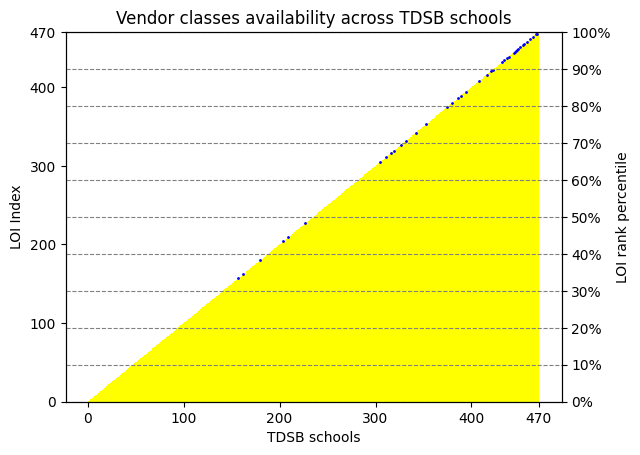

In [147]:
fig, ax = plt.subplots()

# Create secondary y-axis
ax_p = ax.twinx()

# Set the limits of the plot
ax.set_ylim(0, max_rank)
ax_p.set_ylim(0,1)

# Set the ticks and labels for x and y axes
ax.set_yticks(rank_ticks_values)
ax.set_yticklabels(rank_ticks_labels)
ax.set_xticks(rank_ticks_values)
ax.set_xticklabels(rank_ticks_labels)

# Set the ticks and labels for the secondary y-axis (percentages)
ax_p.set_yticks(perc_ticks_values)
ax_p.set_yticklabels(perc_ticks_labels)

# Adding horizontal grid lines at percentage ticks
ax_p.grid(which='major', axis='y', linestyle='--', color='grey')

# Labeling the axes
ax.set_xlabel('TDSB schools')
ax.set_ylabel('LOI Index')
ax_p.set_ylabel('LOI rank percentile')

# Set the title
ax.set_title('Vendor classes availability across TDSB schools')

# Plot the bar chart (with all schools and their index)
ax.bar(loi_rank_list,loi_rank_list, 1, color="yellow")

# Plot the scatter chart (with all schools in the vendor list)
ax.scatter(dfs_join_v_loi.select("loi_rank").collect(), dfs_join_v_loi.select("loi_rank").collect(), 1, color="blue")

# Show the plot
plt.show()

In [144]:
# Generate ticks and labels for buckets
bucket_ticks_values = [x for x in range(0,11)]
bucket_ticks_labels = [str(x*10) + "%" for x in bucket_ticks_values]

# Generate ticks and labels for bucket counts
bucket_count_ticks_values = set(rank_count_list)
bucket_count_ticks_values.add(0)
bucket_count_ticks_values = sorted(bucket_count_ticks_values)
bucket_count_ticks_labels = [str(x) for x in bucket_count_ticks_values]

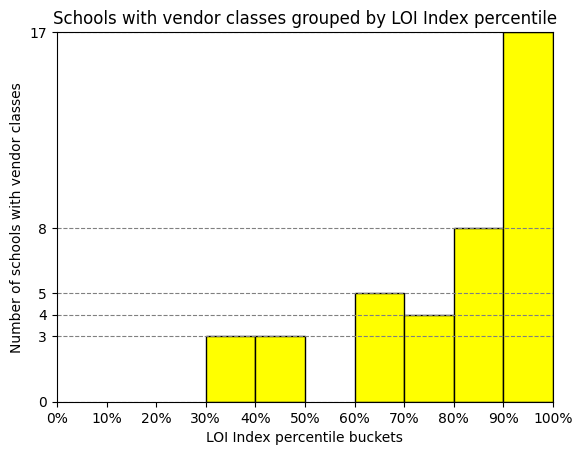

In [148]:
fig, ax = plt.subplots()

# Set the limits of the plot
ax.set_xlim(0, 10)
ax.set_ylim(0, max(rank_count_list))

# Set the ticks and labels for x and y axes
ax.set_xticks(bucket_ticks_values)
ax.set_xticklabels(bucket_ticks_labels)
ax.set_yticks(bucket_count_ticks_values)
ax.set_yticklabels(bucket_count_ticks_labels)

# Adding horizontal grid lines at percentage ticks
ax.grid(which='major', axis='y', linestyle='--', color='grey')

# Labeling the axes
ax.set_xlabel('LOI Index percentile buckets')
ax.set_ylabel('Number of schools with vendor classes')

# Set the title
ax.set_title('Schools with vendor classes grouped by LOI Index percentile')

# Plot the bar chart (with all schools and their index)
ax.bar(rank_bucket_list, rank_count_list, 1, align='edge', color="yellow", edgecolor="black")

# Show the plot
plt.show()